In [1]:
import pandas as pd
import numpy as np
import pdb 
from datetime import datetime, timedelta
from dis import dis
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

data = pd.read_csv("data.csv")

# drop all variables & datapoints not needed
data = data.drop(columns = ["read_id", "topic_id", "contest_id", "problem_id", "origin", "origin_created_at"]) #drop columns not needed
not_gold = data.loc[data['current_labeling_state'] != 'gold_standard'] #drop all non gold_standards
data = data.drop(not_gold.index)

# calculate responsetime in seconds
data['response_submitted_at']= pd.to_datetime(data['response_submitted_at'])
data['problem_appeared_at']= pd.to_datetime(data['problem_appeared_at'])
response_time = (data['response_submitted_at'] - data['problem_appeared_at'])#calculate response time
response_time_seconds = response_time / np.timedelta64(1, 's') #transform to seconds
data['RT'] = response_time_seconds

# outlier removal based on responsetime
data = data.drop(data.loc[data['RT'] <= 0].index) #excludes negative response time (e.g. datetime problem in row 684584)
data = data.drop(data.loc[data['RT'] >= 3600].index) #excludes response time longer than one hour (e.g. app runs without subject paying attention)
def outlier_removal_RT(data, RT_threshold=3*np.std(data['RT'])): #remove all dp with longer RT than 3*std of raw data
    length1 = len(data['RT']) 
    data = data[data['RT'] <= RT_threshold]
    data = data.reset_index()
    length2 = len(data['RT'])
    Avg_RT = np.average(data['RT'])
    SD_RT = np.std(data['RT'])
    print('Average Response Time (in seconds): %.2f' % (Avg_RT))
    print('Response Time SD: %.2f' % (SD_RT),'\n')
    return data

data = outlier_removal_RT(data)

# sort data according to user and order of responses given
data = data.sort_values(
    by=["user_id", "response_submitted_at"]
)

# function for n-back
def get_backward(dataframe, id_col, correct_col, chosen_col, n_back):    
    df = dataframe
    is_valid = df[id_col].value_counts(sort=False)>n_back
    result = np.array([]) # create empty list
    for i, subject in enumerate(np.unique(df[id_col])): # loop over subjects
        if is_valid.values[i] == True:
            true_false_list = np.empty([n_back]) # initialize with nan for first n_back trials
            true_false_list[:] = np.nan # select rows of currect subject
            df_subj = df.loc[df[id_col]==subject,]
            choices_subj = df_subj[chosen_col] 
            correct_subj = df_subj[correct_col] 
            tmp_list = np.array(choices_subj == correct_subj.shift(periods = n_back)) # calculate accuracy (True if choice[t] == correct[t-n_back], else False)
            true_false_list = np.append(true_false_list, tmp_list[n_back:]) # append to inialized list
            result = np.append(result, true_false_list)
            
        elif is_valid.values[i] == False:
            num_rows = df[id_col][df[id_col]==subject].value_counts()
            true_false_list = np.empty([num_rows.values[0]]) # initialize with nan for rows with invalid data
            true_false_list[:] = np.nan
            result = np.append(result, true_false_list)

    return(result)

#append 1-back
data['1back_accuracy'] = get_backward(n_back = 1, dataframe = data, id_col = 'user_id', correct_col = 'current_correct_answer', chosen_col = 'chosen_answer')
#append 2-back
data['2back_accuracy'] = get_backward(n_back = 2, dataframe = data, id_col = 'user_id', correct_col = 'current_correct_answer', chosen_col = 'chosen_answer')
#append 3-back
data['3back_accuracy'] = get_backward(n_back = 3, dataframe = data, id_col = 'user_id', correct_col = 'current_correct_answer', chosen_col = 'chosen_answer')
# result, true_false_list = get_values(n_back = 2, dataframe = data, id_col = 'user_id', correct_col = 'current_correct_answer', chosen_col = 'chosen_answer')


#function for 1-forward
def get_forward(dataframe, id_col, correct_col, chosen_col, n_back):    
    df = dataframe
    is_valid = df[id_col].value_counts(sort=False)>n_back
    result = np.array([]) # create empty list
    for i, subject in enumerate(np.unique(df[id_col])): # loop over subjects
        if is_valid.values[i] == True:
            true_false_list = np.empty(np.abs(n_back)) # initialize with nan for first n_back trials
            true_false_list[:] = np.nan # select rows of currect subject
            df_subj = df.loc[df[id_col]==subject,]
            choices_subj = df_subj[chosen_col] 
            correct_subj = df_subj[correct_col] 
            tmp_list = np.array(choices_subj == correct_subj.shift(periods = n_back)) # calculate accuracy (True if choice[t] == correct[t-n_back], else False)
            true_false_list = np.append(tmp_list[:n_back], true_false_list) # append to inialized list
            result = np.append(result, true_false_list)
            
        elif is_valid.values[i] == False:
            num_rows = df[id_col][df[id_col]==subject].value_counts()
            true_false_list = np.empty([num_rows.values[0]]) # initialize with nan for rows with invalid data
            true_false_list[:] = np.nan
            result = np.append(result, true_false_list)

    return(result)

#append 1-forward
data['1forward_accuracy'] = get_forward(n_back = -1, dataframe = data, id_col = 'user_id', correct_col = 'current_correct_answer', chosen_col = 'chosen_answer')

#calculate vales of interest
print('Number of subjects:', data['user_id'].nunique())
print('Number of trials:', data['index'].nunique(),'\n')

#data['1back_accuracy'].value_counts(1) # how often did 1-back etc. occur?
#print(data['score'].value_counts(1)) # rate of correct answers: 81.2%
#data.groupby(['user_id']).mean() # mean score and mean response time for each subject

print("\033[1m" + 'Values for 1-back:' + "\033[0m")
print('Number of subjects:', data['user_id'][data['1back_accuracy']==1].nunique(),'\n')

#previous: any image
one_back_any = pd.notnull(data['1back_accuracy'])
print('Ratio of chosen answers with any image in 1-back trial:\n',data['chosen_answer'][one_back_any].value_counts(1),'\n')
#previous: nevus
one_back_nevus = data['current_correct_answer'].shift(periods = 1) == "['nevus']"
print('Ratio of "nevus" with nevus image in 1-back trial:\n',data['chosen_answer'][one_back_nevus].value_counts(1)[0],'\n')
#previous: melanoma
one_back_melanoma = data['current_correct_answer'].shift(periods = 1) == "['melanoma']"
print('Ratio of "melanoma" with melanoma image in 1-back trial:\n',data['chosen_answer'][one_back_melanoma].value_counts(1)[1],'\n')


print("\033[1m" + 'Values for 2-back:' + "\033[0m")
print('Number of subjects:', data['user_id'][data['2back_accuracy']==1].nunique(),'\n')

#previous: any image
two_back_any = pd.notnull(data['2back_accuracy'])
print('Ratio of chosen answers with any image in 2-back trial:\n',data['chosen_answer'][two_back_any].value_counts(1),'\n')
#previous: nevus
two_back_nevus = data['current_correct_answer'].shift(periods = 2) == "['nevus']"
print('Ratio of "nevus" with nevus image in 2-back trial:\n',data['chosen_answer'][two_back_nevus].value_counts(1)[0],'\n')
#previous: melanoma
two_back_melanoma = data['current_correct_answer'].shift(periods = 2) == "['melanoma']"
print('Ratio of "melanoma" with melanoma image in 2-back trial:\n',data['chosen_answer'][two_back_melanoma].value_counts(1)[1],'\n')


print("\033[1m" + 'Values for 3-back:' + "\033[0m")
print('Number of subjects:', data['user_id'][data['3back_accuracy']==1].nunique(),'\n')

#previous: any image
three_back_any = pd.notnull(data['3back_accuracy'])
print('Ratio of chosen answers with any image in 3-back trial:\n',data['chosen_answer'][three_back_any].value_counts(1),'\n')
#previous: nevus
three_back_nevus = data['current_correct_answer'].shift(periods = 3) == "['nevus']"
print('Ratio of "nevus" with nevus image in 3-back trial:\n',data['chosen_answer'][three_back_nevus].value_counts(1)[0],'\n')
#previous: melanoma
three_back_melanoma = data['current_correct_answer'].shift(periods = 3) == "['melanoma']"
print('Ratio of "melanoma" with melanoma image in 3-back trial:\n',data['chosen_answer'][three_back_melanoma].value_counts(1)[1],'\n')


print("\033[1m" + 'Values for 1-forward:' + "\033[0m")
print('Number of subjects:', data['user_id'][data['1forward_accuracy']==1].nunique(),'\n')

#previous: any image
one_forward_any = pd.notnull(data['1forward_accuracy'])
print('Ratio of chosen answers with any image in 1-forward trial:\n',data['chosen_answer'][one_forward_any].value_counts(1),'\n')
#previous: nevus
one_forward_nevus = data['current_correct_answer'].shift(periods = -1) == "['nevus']"
print('Ratio of "nevus" with nevus image in 1-forward trial:\n',data['chosen_answer'][one_forward_nevus].value_counts(1)[0],'\n')
#previous: melanoma
one_forward_melanoma = data['current_correct_answer'].shift(periods = -1) == "['melanoma']"
print('Ratio of "melanoma" with melanoma image in 1-forward trial:\n',data['chosen_answer'][one_forward_melanoma].value_counts(1)[1],'\n')


Average Response Time (in seconds): 1.37
Response Time SD: 1.98 

Number of subjects: 1173
Number of trials: 756180 

Values for 1-back:
Number of subjects: 1167 

Ratio of chosen answers with any image in 1-back trial:
 ['nevus']       0.518389
['melanoma']    0.481611
Name: chosen_answer, dtype: float64 

Ratio of "nevus" with nevus image in 1-back trial:
 0.5188845909589516 

Ratio of "melanoma" with melanoma image in 1-back trial:
 0.4826584229191036 

Values for 2-back:
Number of subjects: 1160 

Ratio of chosen answers with any image in 2-back trial:
 ['nevus']       0.518508
['melanoma']    0.481492
Name: chosen_answer, dtype: float64 

Ratio of "nevus" with nevus image in 2-back trial:
 0.5177645632469257 

Ratio of "melanoma" with melanoma image in 2-back trial:
 0.48115907944534014 

Values for 3-back:
Number of subjects: 1155 

Ratio of chosen answers with any image in 3-back trial:
 ['nevus']       0.518636
['melanoma']    0.481364
Name: chosen_answer, dtype: float64 

Rati

In [6]:
data['current_correct_answer'].value_counts(1)

['nevus']       0.572649
['melanoma']    0.427351
Name: current_correct_answer, dtype: float64

In [2]:
data

,index,user_id,score,current_labeling_state,response_submitted_at,problem_appeared_at,current_correct_answer,chosen_answer,RT,1back_accuracy,2back_accuracy,3back_accuracy,1forward_accuracy
406198,407781,2,100,gold_standard,2020-09-04 16:34:02.509000+00:00,2020-09-04 16:33:59.102000+00:00,['nevus'],['nevus'],3.407000,NaN,NaN,NaN,1.0
406207,407790,2,100,gold_standard,2020-09-04 16:34:24.857000+00:00,2020-09-04 16:34:20.576999+00:00,['nevus'],['nevus'],4.280001,1.0,NaN,NaN,1.0
406209,407792,2,100,gold_standard,2020-09-04 16:34:32.915000+00:00,2020-09-04 16:34:26.944000+00:00,['nevus'],['melanoma'],5.971000,0.0,0.0,NaN,0.0
406213,407796,2,100,gold_standard,2020-09-04 16:34:37.391000+00:00,2020-09-04 16:34:34.810000+00:00,['nevus'],['nevus'],2.581000,1.0,1.0,1.0,1.0
406215,407798,2,100,gold_standard,2020-09-04 16:34:39.990999+00:00,2020-09-04 16:34:38.653000+00:00,['nevus'],['nevus'],1.337999,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
756063,758022,132095,100,gold_standard,2021-06-21 02:57:31.355000+00:00,2021-06-21 02:57:29.993000+00:00,['melanoma'],['melanoma'],1.362000,0.0,1.0,0.0,1.0
756066,758025,132095,0,gold_standard,2021-06-21 02:57:34.098000+00:00,2021-06-21 02:57:32.214000+00:00,['melanoma'],['nevus'],1.884000,0.0,1.0,0.0,1.0
756069,758028,132095,100,gold_standard,2021-06-21 02:57:36.079000+00:00,2021-06-21 02:57:35.112999+00:00,['nevus'],['nevus'],0.966001,0.0,0.0,1.0,0.0
756072,758031,132095,100,gold_standard,2021-06-21 02:57:38.096999+00:00,2021-06-21 02:57:37.069999+00:00,['melanoma'],['melanoma'],1.027000,0.0,1.0,1.0,0.0


In [14]:
def nevus_permutation(x, y, permIter = 100):    
    
    OutB = [] # Output a array, store each trial's a
    perm_xdata = x
    for i in range(permIter):
        perm_xdata = np.random.permutation(perm_xdata) # permutate nonlocal xdata to update, don't change ydata #THATS MOST IMPORTANT

        #here we can insert our code for calculating the ratio
        true_false_list = y == "['nevus']"

        numerator = np.unique(perm_xdata[true_false_list], return_counts=True)[1]
        denominator = np.sum(np.unique(perm_xdata[true_false_list], return_counts=True)[1])

        ratio = numerator/denominator

        OutB.append(ratio[1])                   
    return(OutB)



In [54]:
# permutation
y = data['current_correct_answer'].shift(periods = 1)
x = data['chosen_answer']

nevus_ratios = nevus_permutation(x = x, y = y, permIter = 5000)

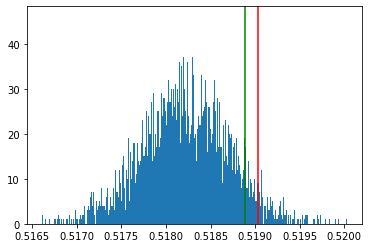

In [55]:
plt.hist(nevus_ratios, bins = 500)
nevus_current_ratio = data['chosen_answer'][one_back_nevus].value_counts(1)[0]
plt.axvline(x=nevus_current_ratio, color='g')
plt.axvline(x=np.percentile(a = nevus_ratios, q = 95), color='r')

In [47]:
#melanoma loop
def melanoma_permutation(x, y, permIter = 100):    
    
    OutB = [] # Output a array, store each trial's a
    perm_xdata = x
    for i in range(permIter):
        perm_xdata = np.random.permutation(perm_xdata) # permutate nonlocal xdata to update, don't change ydata #THATS MOST IMPORTANT

        #here we can insert our code for calculating the ratio
        true_false_list = y == "['melanoma']"

        numerator = np.unique(perm_xdata[true_false_list], return_counts=True)[1]
        denominator = np.sum(np.unique(perm_xdata[true_false_list], return_counts=True)[1])

        ratio = numerator/denominator

        OutB.append(ratio[0])                   
    return(OutB)

In [50]:
# melanoma permutation
melanoma_ratios = melanoma_permutation(x = x, y = y, permIter = 5000)

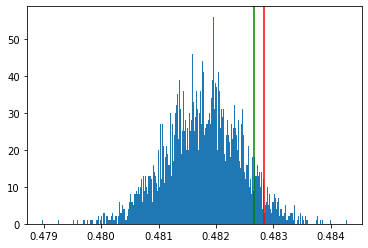

In [56]:
# melanoma plot
plt.hist(melanoma_ratios, bins = 500)
melanoma_current_ratio = data['chosen_answer'][one_back_melanoma].value_counts(1)[1]
plt.axvline(x=melanoma_current_ratio, color='g')
plt.axvline(x=np.percentile(a = melanoma_ratios, q = 95), color='r')